In [335]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature
import os
import numpy as np
import warnings
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import networkx as nx


warnings.filterwarnings('ignore')


In [336]:
airbnbs_df = pd.read_csv("AB_US_2023.csv")

In [337]:
coords = np.radians(airbnbs_df[['latitude', 'longitude']])

kms_per_radian = 6371.0088
epsilon = 0.7 / kms_per_radian  # 0.5 km neighborhood

db = DBSCAN(eps=epsilon, min_samples=100, algorithm='ball_tree', metric='haversine')
airbnbs_df['cluster'] = db.fit_predict(coords)
airbnbs_df = airbnbs_df[airbnbs_df["cluster"] != -1]

Next up, let's compute cluster centroids as the mean of the latitude and longitude values for each group.

In [338]:
airbnbs_df['latitude_deg'] = np.degrees(coords["latitude"])
airbnbs_df['longitude_deg'] = np.degrees(coords["longitude"])
cluster_centers = airbnbs_df.groupby('cluster')[['latitude_deg', 'longitude_deg']].mean().reset_index()

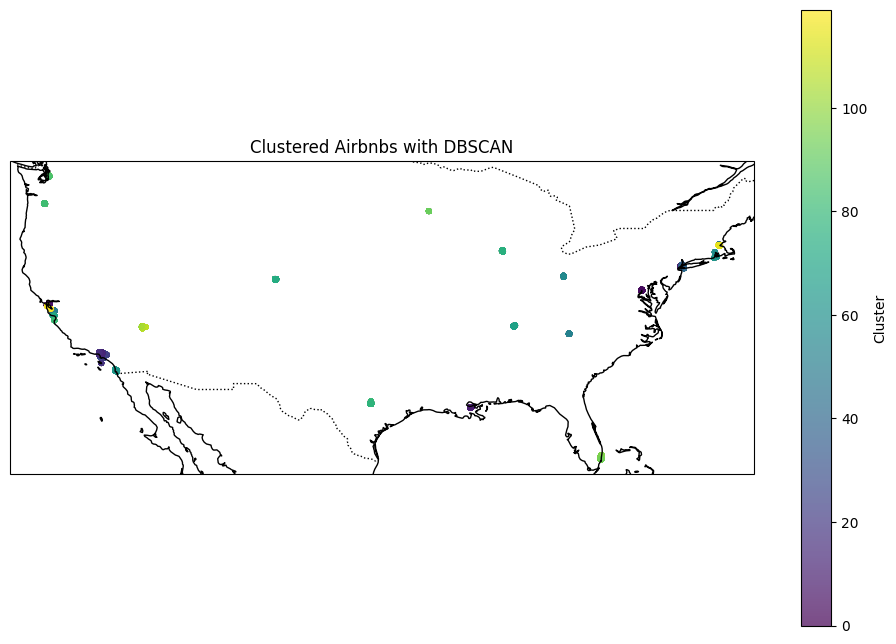

In [339]:
# Plotting the clusters on a map with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Add features to the map
ax.set_title("Clustered Airbnbs with DBSCAN")
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')

# Scatter the points, color them by cluster
scatter = ax.scatter(
    airbnbs_df['longitude'], airbnbs_df['latitude'], c=airbnbs_df['cluster'], 
    cmap='viridis', s=10, transform=ccrs.PlateCarree(), alpha=0.7
)

# Add a colorbar to indicate the cluster labels
plt.colorbar(scatter, ax=ax, label='Cluster')

# Show the plot
plt.show()


Seems like the clustering worked out and the clusters are pretty balanced and really look like clusters on the map. Next up, some feature engineering.

In [340]:
cluster_n = airbnbs_df["cluster"].unique()

cluster_counts = airbnbs_df.groupby('cluster').size()
average_datapoints_per_cluster = cluster_counts.mean()

print("Number of possible nodes:", max(cluster_n))
print("Number of datapoints in total:", len(airbnbs_df))
print(f"Average number of data points per cluster: {average_datapoints_per_cluster:.2f}")

Number of possible nodes: 119
Number of datapoints in total: 142756
Average number of data points per cluster: 1189.63


In [341]:
null_columns = airbnbs_df.isnull().sum()
print("Columns with nulls in them:\n", null_columns)

airbnbs_df.drop(columns=["neighbourhood_group", "last_review", "reviews_per_month", "host_id"], inplace=True)
print("New columns:", airbnbs_df.columns)

Columns with nulls in them:
 id                                    0
name                                 10
host_id                               0
host_name                             9
neighbourhood_group               79673
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       33003
reviews_per_month                 33003
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
city                                  0
cluster                               0
latitude_deg                          0
longitude_deg                         0
dtype: int64
New columns: Index(['id', 'name', 'host_name', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'price', 

One-hot encoding.

In [342]:
print(airbnbs_df.nunique())
room_type_dummies = pd.get_dummies(airbnbs_df['room_type'], prefix='room_type')
city_dummies = pd.get_dummies(airbnbs_df['city'], prefix='city')
airbnbs_df = pd.concat([airbnbs_df, room_type_dummies, city_dummies], axis=1)
airbnbs_df = airbnbs_df.drop(['room_type', 'city'], axis=1)
print(airbnbs_df.columns)

id                                142755
name                              133331
host_name                          18664
neighbourhood                        522
latitude                           90889
longitude                          88938
room_type                              4
price                               2066
minimum_nights                       163
number_of_reviews                    793
calculated_host_listings_count       148
availability_365                     366
number_of_reviews_ltm                260
city                                  26
cluster                              120
latitude_deg                       90888
longitude_deg                      88937
dtype: int64
Index(['id', 'name', 'host_name', 'neighbourhood', 'latitude', 'longitude',
       'price', 'minimum_nights', 'number_of_reviews',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'cluster', 'latitude_deg', 'longitude_deg',
       'room_type_Enti

Scaling the numerical features.

In [343]:
scaler = StandardScaler()
numerical_cols = ["minimum_nights", "number_of_reviews", "calculated_host_listings_count", "number_of_reviews_ltm", "availability_365"]
airbnbs_df[numerical_cols] = scaler.fit_transform(airbnbs_df[numerical_cols])
airbnbs_df.head()

,id,name,host_name,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,...,city_Portland,city_Rhode Island,city_San Diego,city_San Francisco,city_San Mateo County,city_Santa Clara County,city_Santa Cruz County,city_Seattle,city_Twin Cities MSA,city_Washington D.C.
0,958,"Bright, Modern Garden Unit - 1BR/1BTH",Holly,Western Addition,37.77028,-122.43317,202,-0.454009,4.197154,-0.313470,...,False,False,False,True,False,False,False,False,False,False
1,5858,Creative Sanctuary,Philip And Tania,Bernal Heights,37.74474,-122.42089,235,0.534759,0.866573,-0.313470,...,False,False,False,True,False,False,False,False,False,False
2,8142,Friendly Room Apt. Style -UCSF/USF - San Franc...,Aaron,Haight Ashbury,37.76555,-122.45213,56,0.605385,-0.382395,-0.218668,...,False,False,False,True,False,False,False,False,False,False
3,8339,Historic Alamo Square Victorian,Rosy,Western Addition,37.77564,-122.43642,575,-0.206817,-0.149744,-0.305570,...,False,False,False,True,False,False,False,False,False,False
4,8739,"Mission Sunshine, with Private Bath",Ivan & Wendy,Mission,37.76030,-122.42197,110,-0.489322,8.935886,-0.305570,...,False,False,False,True,False,False,False,False,False,False


Next up, we should create a graph from the data with carefully chosen edges. The edges are chosen with a two-step approach:
1. First, we determine a vector representation for each node by training them with GMM and then getting the model weights.
2. Then, we construct the discrepancy between neighboring nodes via the distance between the vector representations.

In [353]:

G = nx.Graph()

clusters = airbnbs_df['cluster'].unique()
G.add_nodes_from(clusters)
print()
for C in clusters:
    cluster_data = airbnbs_df[airbnbs_df["cluster"] == C]
    X = airbnbs_df.drop(columns=['price'])  # All columns except 'price'
    centre = cluster_centers.iloc[C].tolist()[1:]
    y = airbnbs_df['price']
    G.nodes[C]["X"] = X
    G.nodes[C]["y"] = y
    G.nodes[C]["center"] = centre
    


[37.77548993996263, -122.4206557974878]
